# Portfolio based on Capital Asset Pricing Model
* note: assuming risk-free rate of 0
* Our Hypothesis: Stock Alpha Is Persistent (Note: this is a momentum strategy)

*The stock selection and portfolio construction is as follows:*
* Step 1: at each month-end date, we calculate CAPM-implied idiosyncractic mean returns (security's Jensen's alpha) of all stocks based on past 3 years of observations

* Step 2: based on the results of Step 1, we include all stocks in the top quartile based on their alpha rankings, and build an equal-weighted portfolio

* Step 3: the portfolio would be held for one month and be rebalanced at each month-end date

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### *Data Processing*

In [2]:
# Load Data
df_stock_info = pd.read_excel('DataSource.xlsx',sheetname='StockList',index_col=[0])
df_stock_info = df_stock_info[df_stock_info.columns[0:6]]

df_price = pd.read_excel('DataSource.xlsx',sheetname='StockMonthlyPrices',parse_dates=True)[0:506].T
df_price = df_price.rename(df_price.iloc[0],axis=1)
df_price = df_price.drop(df_price.index[0])
df_price = df_price.drop(df_price.columns[[-1]],axis=1)
df_price = df_price.astype('float')

df_market = pd.read_excel('DataSource.xlsx',sheetname='CAPMAssets', header=2,parse_dates=[0],index_col=[0])
spy_ret = df_market['S&P - 500 Index']
spy_ret = spy_ret.to_period('M')

In [3]:
# Calculate Return
df_ret = df_price/df_price.shift(1)-1
df_ret = df_ret.set_index(pd.to_datetime(df_price.index))
df_ret = df_ret.to_period('M')

In [4]:
# starting from 2004-12-31 (so we have enough observations)
spy_ret = spy_ret.truncate(before=pd.Timestamp('2004-12'))/100
df_ret = df_ret.truncate(before=pd.Timestamp('2004-12'))
stocks_ret = df_ret.copy()
df_ret['market'] = spy_ret

In [5]:
spy_ret.head()

Period Ending
2004-12    0.034029
2005-01   -0.024375
2005-02    0.021044
2005-03   -0.017708
2005-04   -0.018966
Freq: M, Name: S&P - 500 Index, dtype: float64

In [6]:
df_ret.head()

,88579Y101,002824100,00287Y109,003654100,G1151C101,00507V109,00724F101,00751Y106,007903107,00130H105,...,983134107,98389B100,984121608,983919101,98419M100,988498101,98956P102,989701107,98978V103,market
2004-12,0.031157,0.111774,NaN,0.017128,0.040864,0.283695,0.036202,0.058640,0.034774,0.116830,...,0.152006,0.019205,0.110313,-0.049645,NaN,0.039209,-0.018137,0.023007,NaN,0.034029
2005-01,0.027904,-0.029596,NaN,-0.230570,-0.035185,0.119934,-0.093083,-0.013290,-0.282470,0.027798,...,-0.020323,-0.000551,-0.066431,-0.016181,NaN,-0.015457,-0.015851,-0.003086,NaN,-0.024375
2005-02,0.000000,0.021544,NaN,-0.099327,-0.019194,-0.032755,0.085239,0.168935,0.104430,0.191459,...,0.091672,-0.025838,-0.017632,0.036344,NaN,0.052425,0.089410,-0.020266,NaN,0.021044
2005-03,0.020851,0.013701,NaN,-0.011215,-0.054795,-0.097282,0.087979,0.001370,-0.076218,-0.021505,...,-0.053514,-0.018331,-0.028847,-0.032118,NaN,0.062115,-0.094179,0.044176,NaN,-0.017708
2005-04,-0.107604,0.060518,NaN,-0.040643,-0.101449,-0.022973,-0.114637,0.057503,-0.117246,-0.018315,...,-0.218482,0.000000,-0.125413,-0.078343,NaN,-0.091828,0.046395,0.014633,NaN,-0.018966


In [7]:
stocks_ret.head()

,88579Y101,002824100,00287Y109,003654100,G1151C101,00507V109,00724F101,00751Y106,007903107,00130H105,...,G96629103,983134107,98389B100,984121608,983919101,98419M100,988498101,98956P102,989701107,98978V103
2004-12,0.031157,0.111774,NaN,0.017128,0.040864,0.283695,0.036202,0.058640,0.034774,0.116830,...,0.092662,0.152006,0.019205,0.110313,-0.049645,NaN,0.039209,-0.018137,0.023007,NaN
2005-01,0.027904,-0.029596,NaN,-0.230570,-0.035185,0.119934,-0.093083,-0.013290,-0.282470,0.027798,...,-0.060481,-0.020323,-0.000551,-0.066431,-0.016181,NaN,-0.015457,-0.015851,-0.003086,NaN
2005-02,0.000000,0.021544,NaN,-0.099327,-0.019194,-0.032755,0.085239,0.168935,0.104430,0.191459,...,0.022492,0.091672,-0.025838,-0.017632,0.036344,NaN,0.052425,0.089410,-0.020266,NaN
2005-03,0.020851,0.013701,NaN,-0.011215,-0.054795,-0.097282,0.087979,0.001370,-0.076218,-0.021505,...,-0.062187,-0.053514,-0.018331,-0.028847,-0.032118,NaN,0.062115,-0.094179,0.044176,NaN
2005-04,-0.107604,0.060518,NaN,-0.040643,-0.101449,-0.022973,-0.114637,0.057503,-0.117246,-0.018315,...,-0.092758,-0.218482,0.000000,-0.125413,-0.078343,NaN,-0.091828,0.046395,0.014633,NaN


### *Build the Portfolio*

In [8]:
import statsmodels.api as sm

In [9]:
# Define regression function given sample period to get alpha
def regression(data):
    X = data.drop('market',axis=1)
    Y = data['market']
    
    # Get the array of alpha and beta for differnt stocks
    # During the same sample period    
    a = []
    
    for i in X.columns:
        # we cannot run a regression when all values are NAN
        if np.nansum(X[i]) == 0:
            alpha = np.nan
        else:
            x = sm.add_constant(X[i])
            models = sm.OLS(Y,x,missing='drop').fit()
            alpha = models.params[0]
        a = np.hstack((a,alpha)) 
        
    return a


# Define windows function

def rollingwins(data,periods):
    return [data[i-periods:i] for i in range(periods,data.shape[0]+1)]


In [10]:
# number of stocks
num_stock=df_price.shape[1];

# look-back period for observing stock beta
# in default, we'll use past 36 months
periods=3*12

In [11]:
# Rolling windows regression
wins = rollingwins(df_ret,periods)

In [12]:
# Get the alpha for each stock during the same time 
alpha = [regression(win) for win in wins]

In [13]:
df_alpha = pd.DataFrame(alpha,columns=df_price.columns)
df_alpha = df_alpha.set_index(df_ret[periods-1:].index)

In [14]:
# Asset Selection 
def asset_selection_top(data,quantile):
    # The quantile doesn't include the NaN
    data.dropna(inplace=True)
    n = len(data)
    data = data.sort_values(ascending=False)
    x = data[:int(n*quantile)+1].index
    return x

def asset_selection_bottom(data,quantile):
    # The quantile doesn't include the NaN
    data.dropna(inplace=True)
    n = len(data)
    data = data.sort_values(ascending=True)
    x = data[:int(n*quantile)+1].index
    return x

In [15]:
# Question?
# The quantile includes the NaN
date1 = df_alpha.iloc[0]

m = date1.sort_values(ascending=False)

m[:125].index

Index(['90384S303', '254709108', '410345102', '101137107', '526057104',
       '745867101', '23331A109', '57772K101', '14040H105', '269246401',
       ...
       '256746108', '09062X103', '478160104', '55616P104', '579780206',
       '832696405', '609207105', '88579Y101', '723484101', '756577102'],
      dtype='object', length=125)

In [16]:
asset_selection_top(date1,0.25)

Index(['90384S303', '254709108', '410345102', '101137107', '526057104',
       '745867101', '23331A109', '57772K101', '14040H105', '269246401',
       ...
       '31428X106', '48203R104', '770323103', '45337C102', '532457108',
       '500255104', '713448108', 'G0177J108', '83088M102', '747525103'],
      dtype='object', length=113)

In [17]:
asset_pool_buy = [asset_selection_top(df_alpha.iloc[i],0.25) for i in range(len(df_alpha)) ]
asset_pool_sell = [asset_selection_bottom(df_alpha.iloc[i],0.25) for i in range(len(df_alpha)) ]

In [18]:
asset_pool_buy[:2]

[Index(['90384S303', '254709108', '410345102', '101137107', '526057104',
        '745867101', '23331A109', '57772K101', '14040H105', '269246401',
        ...
        '31428X106', '48203R104', '770323103', '45337C102', '532457108',
        '500255104', '713448108', 'G0177J108', '83088M102', '747525103'],
       dtype='object', length=113),
 Index(['254709108', '410345102', '101137107', '526057104', '745867101',
        '14040H105', '269246401', '345370860', '316773100', '23331A109',
        ...
        '060505104', '285512109', '609207105', '713448108', '364760108',
        '770323103', '620076307', '21036P108', '532457108', '87612E106'],
       dtype='object', length=113)]

In [19]:
asset_pool_sell[:2]

[Index(['20605P101', 'H84989104', '540424108', '580135101', '40434L105',
        '247361702', '59156R108', '032095101', '74144T108', '253868103',
        ...
        '22822V101', '501044101', '65339F101', '015271109', '674599105',
        '001055102', '25179M103', '95040Q104', 'G0408V102', '023608102'],
       dtype='object', length=113),
 Index(['90384S303', '20605P101', '55354G100', 'H84989104', '540424108',
        '369550108', '580135101', '40434L105', '032095101', '302491303',
        ...
        'H1467J104', '097023105', '61945C103', '47233W109', '92939U106',
        '828806109', '149123101', 'G87110105', '92276F100', '02079K305'],
       dtype='object', length=113)]

In [20]:
# Portfolio construction and get its montly return
# Strategy0: Buy the top 25% quantile stocks
port_ret = []
stocks_used_ret = stocks_ret[periods-1:].shift(-1)
for i in range(len(stocks_used_ret)-1):
    ret = stocks_used_ret.iloc[i+1]
    buy = ret[asset_pool_buy[i]]
    ret = np.sum(buy)/len(buy) 
    port_ret.append(ret)

In [21]:
port_ret = np.array(port_ret).reshape(-1,1)
df_port = pd.DataFrame(port_ret,index = stocks_used_ret.index[1:])
df_port = df_port.rename(columns = {0:'S0_return'})

df_port['S0_Value'] = 100*(1+df_port['S0_return']).cumprod()
df_port.head()

,S0_return,S0_Value
2007-12,0.002554,100.255436
2008-01,-0.044178,95.826311
2008-02,-0.011721,94.703144
2008-03,0.044876,98.953046
2008-04,0.017220,100.657058


In [22]:
# Portfolio construction and get its montly return
# Strategy1: Buy the top 25% quantile stocks and Sell the bottom 25% quantile stocks
port_ret1 = []
stocks_used_ret = stocks_ret[periods-1:].shift(-1)
for i in range(len(stocks_used_ret)-1):
    ret = stocks_used_ret.iloc[i+1]
    buy = ret[asset_pool_buy[i]]
    sell = ret[asset_pool_sell[i]]
    buy_ret = np.sum(buy)/len(buy) 
    sell_ret = -np.sum(sell)/len(sell) 
    ret = buy_ret + sell_ret
    port_ret1.append(ret)

port_ret1 = np.array(port_ret1).reshape(-1,1)
df_port['S1_return'] = port_ret1
df_port['S1_Value'] = 100*(1+df_port['S1_return']).cumprod()
df_port.head()

,S0_return,S0_Value,S1_return,S1_Value
2007-12,0.002554,100.255436,0.084336,108.433646
2008-01,-0.044178,95.826311,-0.039822,104.115586
2008-02,-0.011721,94.703144,-0.007303,103.355179
2008-03,0.044876,98.953046,-0.028604,100.398849
2008-04,0.017220,100.657058,-0.026755,97.712692


### *Performance summary*

In [23]:
def describePerformance(Data,alpha=0.05):
    x = Data.describe()
    x.drop(['25%','75%'], inplace=True)
    x.loc['annualized ret'] = ((Data+1).prod())**(12/len(Data))
    x.loc['annualized std'] = x.loc['std'] * np.sqrt(12)
    x.loc['sharpe']  = x.loc['mean'] / x.loc['std'] * np.sqrt(12)
    x.loc['fracpos'] = (Data>=0).mean()
    x.loc['t score'] = (x.loc['mean'] / (x.loc['std'] * np.sqrt(len(Data))))
    x.loc['VaR'] = Data.quantile(alpha)
    x.loc['CVaR'] = Data[Data<=x.loc['VaR']].mean()
    return x

In [24]:
df_port['Market_return'] = spy_ret
df_port['Market_Value'] = 100*(1+df_port['Market_return']).cumprod()

In [25]:
df_port.head()

,S0_return,S0_Value,S1_return,S1_Value,Market_return,Market_Value
2007-12,0.002554,100.255436,0.084336,108.433646,-0.006938,99.306237
2008-01,-0.044178,95.826311,-0.039822,104.115586,-0.059982,93.349687
2008-02,-0.011721,94.703144,-0.007303,103.355179,-0.032486,90.317152
2008-03,0.044876,98.953046,-0.028604,100.398849,-0.004318,89.927167
2008-04,0.017220,100.657058,-0.026755,97.712692,0.048703,94.306902


*Statistical Assessment*

In [26]:
describePerformance(df_port[['S0_return','S1_return','Market_return']])

,S0_return,S1_return,Market_return
count,133.000000,133.000000,133.000000
mean,0.014217,0.003881,0.006711
std,0.063062,0.038859,0.043378
min,-0.214061,-0.065504,-0.167948
50%,0.016344,-0.001172,0.011119
max,0.368639,0.287937,0.109293
annualized ret,1.157981,1.038883,1.071339
annualized std,0.218453,0.134611,0.150266
sharpe,0.780974,0.345985,0.535914
fracpos,0.654135,0.481203,0.669173


Text(0, 0.5, 'Portfolio Value')

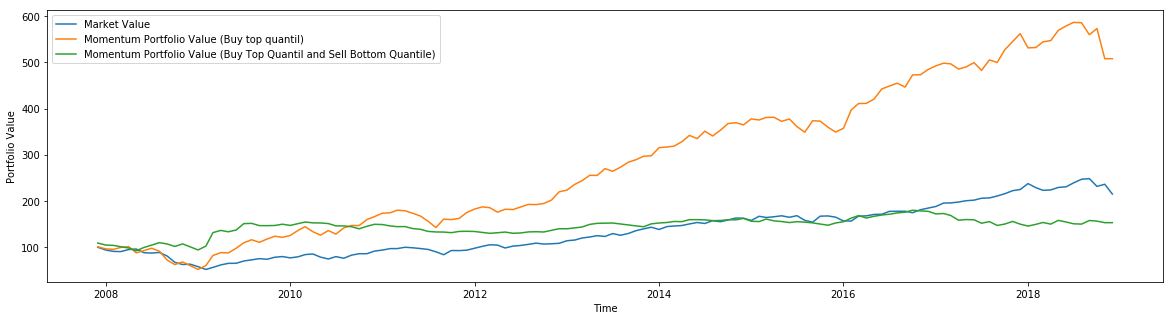

In [27]:
plt.figure(figsize=(20,5))
plt.plot(df_port['Market_Value'].to_timestamp(),label = 'Market Value')
plt.plot(df_port['S0_Value'].to_timestamp(),label='Momentum Portfolio Value (Buy top quantil)')
plt.plot(df_port['S1_Value'].to_timestamp(),label='Momentum Portfolio Value (Buy Top Quantil and Sell Bottom Quantile)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Portfolio Value')

*Maximum Drawdown*

In [30]:
def Maximum_DD(data):
    # Calculate daily MDD
    window = len(data)
    Roll_Max = data.rolling(window,min_periods=1).max()
    Daily_DD = data/Roll_Max - 1.0
    Max_Daily_DD = Daily_DD.rolling(window,min_periods=1).min()
    # Locate when it happened
    MaxDD = Max_Daily_DD.min()
    MaxDD_d_date = Max_Daily_DD.idxmin()
    MaxDD_d = data.loc[MaxDD_d_date]
    MaxDD_u_date = data.loc[:MaxDD_d_date].idxmax()
    MaxDD_u = data.loc[:MaxDD_d_date].max()
    
    print('The Maximum Drawdown is %f'% MaxDD)
    print('When did the Maximum Drawdown happen :',str(MaxDD_d_date)[0:10])
    print('When did the maximum price of the MDD happen: ',str(MaxDD_u_date)[0:10])
    print('What the maximum price of the MDD : ',MaxDD_u)
    print('What the minimum price of the MDD : ',MaxDD_d)
    
    return Daily_DD,Max_Daily_DD,MaxDD,MaxDD_d_date,MaxDD_u_date,MaxDD_u,MaxDD_d

In [31]:
Daily_DD_0,Max_Daily_DD_0,MaxDD_0,MaxDD_d_date_0,MaxDD_u_date_0,MaxDD_u_0,MaxDD_d_0 = Maximum_DD(df_port['S0_Value'])

The Maximum Drawdown is -0.490878
When did the Maximum Drawdown happen : 2009-01
When did the maximum price of the MDD happen:  2008-04
What the maximum price of the MDD :  100.65705833625209
What the minimum price of the MDD :  51.246753690544764


In [32]:
Daily_DD_1,Max_Daily_DD_1,MaxDD_1,MaxDD_d_date_1,MaxDD_u_date_1,MaxDD_u_1,MaxDD_d_1 = Maximum_DD(df_port['S1_Value'])

The Maximum Drawdown is -0.191735
When did the Maximum Drawdown happen : 2018-01
When did the maximum price of the MDD happen:  2016-10
What the maximum price of the MDD :  179.68626484677253
What the minimum price of the MDD :  145.23416872816642


In [33]:
Daily_DD_m,Max_Daily_DD_m,MaxDD_m,MaxDD_d_date_m,MaxDD_u_date_m,MaxDD_u_m,MaxDD_d_m = Maximum_DD(df_port['Market_Value'])

The Maximum Drawdown is -0.484510
When did the Maximum Drawdown happen : 2009-02
When did the maximum price of the MDD happen:  2007-12
What the maximum price of the MDD :  99.306237
What the minimum price of the MDD :  51.191402527845334


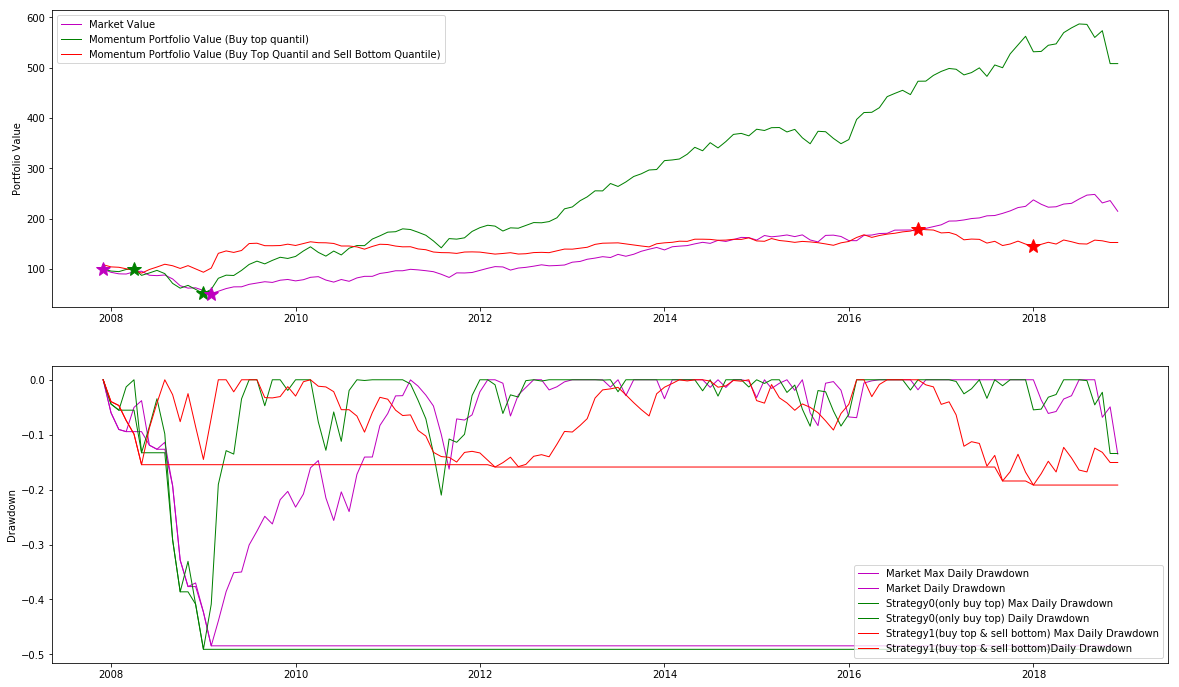

In [34]:
fig = plt.figure(figsize=(20,12))
ax1 = fig.add_subplot(2,1,2)
ax2 = fig.add_subplot(2,1,1)
ax1.plot(Max_Daily_DD_m.to_timestamp(),label='Market Max Daily Drawdown',c='m',lw=1)
ax1.plot(Daily_DD_m.to_timestamp(),label='Market Daily Drawdown',c='m',linewidth=1)
ax1.plot(Max_Daily_DD_0.to_timestamp(),label='Strategy0(only buy top) Max Daily Drawdown',c='g',lw=1)
ax1.plot(Daily_DD_0.to_timestamp(),label='Strategy0(only buy top) Daily Drawdown',c='g',linewidth=1)
ax1.plot(Max_Daily_DD_1.to_timestamp(),label='Strategy1(buy top & sell bottom) Max Daily Drawdown',c='r',lw=1)
ax1.plot(Daily_DD_1.to_timestamp(),label='Strategy1(buy top & sell bottom)Daily Drawdown',c='r',linewidth=1)
ax1.set_ylabel('Drawdown')
ax1.legend(loc=4)

ax2.plot(df_port['Market_Value'].to_timestamp(),label = 'Market Value',c='m',lw=1)
ax2.plot(df_port['S0_Value'].to_timestamp(),label='Momentum Portfolio Value (Buy top quantil)',c='g',lw=1)
ax2.plot(df_port['S1_Value'].to_timestamp(),label='Momentum Portfolio Value (Buy Top Quantil and Sell Bottom Quantile)',c='r',lw=1)
ax2.legend()

ax2.plot(MaxDD_d_date_0.to_timestamp(),MaxDD_d_0,marker="*",c='g',ms=15)
ax2.plot(MaxDD_u_date_0.to_timestamp(),MaxDD_u_0,marker="*",c='g',ms=15)
ax2.plot(MaxDD_d_date_1.to_timestamp(),MaxDD_d_1,marker="*",c='r',ms=15)
ax2.plot(MaxDD_u_date_1.to_timestamp(),MaxDD_u_1,marker="*",c='r',ms=15)
ax2.plot(MaxDD_d_date_m.to_timestamp(),MaxDD_d_m,marker="*",c='m',ms=15)
ax2.plot(MaxDD_u_date_m.to_timestamp(),MaxDD_u_m,marker="*",c='m',ms=15)
ax2.set_ylabel('Portfolio Value')
ax2.legend(loc='upper left')